# Wrangle and Analyze Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gathering">Data Gathering</a></li>
<li><a href="#assessing">Assessing Data</a></li>
<li><a href="#cleaning">Cleaning Data</a></li>
<li><a href="#storing">Storing Data</a></li>
<li><a href="#analyzing">Analyzing and Visualizing Data</a></li>
<li><a href="#conclusion">Conclusion</a></li>
</ul>

<a id="intro"></a>
## Introduction

This project is about **analyzing** the tweet archive of Twitter user @dog_rates, also known as WeRateDogs.This  Twitter account rates people's dogs with a humorous comment about the dog and it has over 4 million followers and has received international media coverage. The twitter archive does not have all the necessary data and we will **gather** missing data from twitter using an API, **assess** the quality and tidiness of data, we will also **clean** the dirty data, **store** the cleaning data in a new dataframe and finally **visualize** our findings.   



<a id="gathering"></a>
## Data Gathering

In [1]:
#Importing required libraries
import requests
import os
import io
import time
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
import tweepy
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display
from tweepy import OAuthHandler
from timeit import default_timer as timer
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from io import BytesIO
from PIL import Image
#from dotenv import reload_dotenv #uncomment for API

%matplotlib inline

1. Gathering the WeRateDogs Twitter archive

In [2]:
# Loading archive data and printing out a first two lines. 
archive = pd.read_csv("twitter-archive-enhanced.csv")
archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


2. Gathering the tweet image predictions

In [3]:
# Downloading the image prediction file
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response=requests.get(url).content
image_prediction=pd.read_csv(io.StringIO(response.decode("utf-8")), sep="\t")
image_prediction.to_csv('image_predictions.tsv')
image_prediction.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


3. Gathering tweet_id,favorite_count, and retweet_count from API and tweet_json.txt

Below codes are used to fetch missing archive data from Twitter using API; **.env** file should be in the `same directory` and contains API credentials.

In [4]:
# #Getting Twitter API keys from .env file and authenticating
# load_dotenv()

# auth = tweepy.OAuthHandler(os.environ.get('consumer_key'), os.environ.get('consumer_secret'))
# auth.set_access_token(os.environ.get('access_token'), os.environ.get('access_secret'))

# api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), 
#                                   wait_on_rate_limit = True)

# # Querying Twitter's API data

# # Starting the timer
# start = time.time()

# tweet_ids = archive.tweet_id.values

# tweets_data = []
# tweet_success = []
# tweet_failure = []

# for tweet_id in tweet_ids:
#         try:
#             data = api.get_status(tweet_id, tweet_mode='extended')
#             tweets_data.append(data)
#             tweet_success.append(tweet_id)
#         except:
#             tweet_failure.append(tweet_id)
#             print(tweet_id)

# # Stopping the timer            
# end = time.time()

# print(end - start)

# Storing data in tweet_json.txt
# with open('tweet_json.txt', mode = 'w') as file:
#     json.dump(tweets_data, file)

# # Loading Twitter API data into a dataframe
# twitter_json = pd.read_json('tweet_json.txt')
# twitter_json['tweet_id'] = tweet_success
# twitter_json = twitter_json[['tweet_id', 'favorite_count', 'retweet_count']]

Using provided tweet_json.txt file

In [5]:
# Loading Twitter json data
twitter_json = pd.read_json('tweet_json.txt', lines=True)
twitter_json.head(3)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


In [6]:
#Converting json file into csv
twitter_json.to_csv('twitter_json.csv')
twitter_data= pd.read_csv('twitter_json.csv')
twitter_data.head()

,Unnamed: 0,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",...,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",...,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",...,42908,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",...,41048,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


<a id="assessing"></a>
## Assessing Data
In this section we will document  **eight quality** issues and **two tidiness** issue**. And we will use visual and 
programmatic assessement to assess the data.

1. Assessing Archive Dataframe

In [7]:
#Checking archive data types
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [8]:
#Showing first two rows
archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [9]:
#Showing random five rows
archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
741,780496263422808064,NaN,NaN,2016-09-26 19:56:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bell. She likes holding...,7.424232e+17,4.196984e+09,2016-06-13 18:27:32 +0000,https://twitter.com/dog_rates/status/742423170...,12,10,Bell,None,None,None,None
1704,680889648562991104,NaN,NaN,2015-12-26 23:15:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cheesy. It's her birthday. She's patie...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680889648...,9,10,Cheesy,None,None,None,None
384,826958653328592898,NaN,NaN,2017-02-02 01:01:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Loki. He smiles like Elvis. Ain't noth...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/826958653...,12,10,Loki,doggo,None,None,None
1702,680934982542561280,NaN,NaN,2015-12-27 02:15:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Sadie. She's a Tortellini Sidewin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680934982...,10,10,Sadie,None,None,None,None
1230,713411074226274305,NaN,NaN,2016-03-25 17:03:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we see an extremely rare Bearded Floofmal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713411074...,11,10,None,None,None,None,None


In [10]:
# Displaying archive's statistical summary
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [11]:
# Displaying counts of different tweets sources 
archive['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

2. Assessing Images Dataframe

In [12]:
# Checking Images data types 
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
# Printing first two rows
image_prediction.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [14]:
# Printing random five rows
image_prediction.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1801,831939777352105988,https://pbs.twimg.com/media/C4uk0EWWQAAaZm1.jpg,1,Pomeranian,0.153862,True,marmot,0.091234,False,grey_fox,0.090644,False
62,667160273090932737,https://pbs.twimg.com/media/CUI6uuaW4AAvCIs.jpg,1,golden_retriever,0.471351,True,miniature_poodle,0.091992,True,standard_poodle,0.087385,True
335,672205392827572224,https://pbs.twimg.com/media/CVQnPMrVAAAzShR.jpg,1,carton,0.952613,False,crate,0.035376,False,pug,0.003267,True
422,674051556661161984,https://pbs.twimg.com/media/CVq2UHwWEAAduMw.jpg,1,Shih-Tzu,0.179777,True,badger,0.160580,False,three-toed_sloth,0.132154,False
1798,831650051525054464,https://pbs.twimg.com/media/C4qdThOWAAI3WX3.jpg,1,Eskimo_dog,0.530416,True,Siberian_husky,0.180335,True,Norwegian_elkhound,0.104314,True


In [15]:
# Displaying Images's statistical summary
image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [16]:
# Displaying counts of predicted dogs
image_prediction['p1_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

3. Assessing Twutter's API dataframe

In [17]:
# Checking API data types
twitter_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

In [18]:
# Printing first two rows
twitter_json.head(2)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


In [19]:
# Printing random five rows 
twitter_json.sample(5)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
1215,2016-03-29 23:49:30+00:00,714962719905021952,714962719905021952,Just in case anyone's having a bad day. 12/10 ...,False,"[0, 87]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",NaN,...,8028,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2124,2015-11-27 20:30:30+00:00,670338931251150849,670338931251150848,This is Butters. He's not ready for Thanksgivi...,False,"[0, 103]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 670338915237167104, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,451,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
956,2016-07-08 16:44:23+00:00,751456908746354688,751456908746354688,Here's a pupper that's very hungry but too laz...,False,"[0, 98]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 751456786360725504, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,3516,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1557,2016-01-17 02:23:42+00:00,688547210804498433,688547210804498432,This is Frönq. He got caught stealing a waffle...,False,"[0, 91]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 688547202457858048, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,2862,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1479,2016-01-30 03:52:58+00:00,693280720173801472,693280720173801472,This is Sadie and her 2 pups Shebang &amp; Ruf...,False,"[0, 143]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 693280713496469504, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,3669,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


In [20]:
# Displaying API's statistical summary
twitter_json.describe()

,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,geo,coordinates,contributors,retweet_count,favorite_count,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str
count,2.354000e+03,2.354000e+03,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,0.0,0.0,0.0,2354.000000,2354.000000,2211.0,2211.0,2.900000e+01,2.900000e+01
mean,7.426978e+17,7.426978e+17,7.455079e+17,7.455079e+17,2.014171e+16,2.014171e+16,NaN,NaN,NaN,3164.797366,8080.968564,0.0,0.0,8.162686e+17,8.162686e+17
std,6.852812e+16,6.852812e+16,7.582492e+16,7.582492e+16,1.252797e+17,1.252797e+17,NaN,NaN,NaN,5284.770364,11814.771334,0.0,0.0,6.164161e+16,6.164161e+16
min,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,6.721083e+17,6.721083e+17
25%,6.783975e+17,6.783975e+17,6.757419e+17,6.757419e+17,3.086374e+08,3.086374e+08,NaN,NaN,NaN,624.500000,1415.000000,0.0,0.0,7.888183e+17,7.888183e+17
50%,7.194596e+17,7.194596e+17,7.038708e+17,7.038708e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,1473.500000,3603.500000,0.0,0.0,8.340867e+17,8.340867e+17
75%,7.993058e+17,7.993058e+17,8.257804e+17,8.257804e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,3652.000000,10122.250000,0.0,0.0,8.664587e+17,8.664587e+17
max,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,NaN,NaN,NaN,79515.000000,132810.000000,0.0,0.0,8.860534e+17,8.860534e+17


### Quality issues
1. Columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp,and expanded_urls have empty columns,

2. Source column in archive_df contain irrelevent values

3. rating_numerator and rating_denominator should be  float not int format

4. Timestamp should should be date and time format

5. name from archive_df values are not irrelevent and wrong capitalization

6. Columns p1, p2, and p3 from prediction_df dataset are wrong capitalization

7. Remove Rt from the text variable

8. tweet id in all three data set should be object

### Tidiness issues
9. In prediction_df  data frame, columns doggo, pupper, flooter, and puppo should be one single column, similarly p1, p2, and p3 shoulb also be one column containing all those informatiom. 

10. A single observational unit is stored in multiple tables

<a id="cleaning"></a>
## Cleaning Data

We are going to make a copy of all data sets and clean above identifed issues. Some issues will be cleaning after we merge all data sets

In [21]:
# Making copies of original pieces of data
archive_clean=archive.copy()
image_prediction_clean=image_prediction.copy()
twitter_json_clean=twitter_json.copy()

### Issue #1: Columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls have empty columns,

#### Define: 
Removing columns with a lot of missing values

#### Code

In [22]:
# Droping unwanted columns
archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [23]:
# Checking if columns are dropped
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   timestamp           2356 non-null   object
 2   source              2356 non-null   object
 3   text                2356 non-null   object
 4   expanded_urls       2297 non-null   object
 5   rating_numerator    2356 non-null   int64 
 6   rating_denominator  2356 non-null   int64 
 7   name                2356 non-null   object
 8   doggo               2356 non-null   object
 9   floofer             2356 non-null   object
 10  pupper              2356 non-null   object
 11  puppo               2356 non-null   object
dtypes: int64(3), object(9)
memory usage: 221.0+ KB


### Issue #2: Source column in archive_df contain irrelevent values

#### Define

Remove links from source column

#### Code

In [24]:
# removing link from source column
archive_clean['source'] = archive_clean['source'].str.extract('^<a.+>(.+)</a>$')

#### Test

In [25]:
# Checking if links are removed
archive_clean.source.value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

### Issue 3: rating_numerator and rating_denominator should be float not int format

####  Define

Change rating_numerator and rating_denominator columns from int to float data types 

#### Code

In [26]:
# Converting int to float
archive_clean['rating_numerator'] = archive_clean['rating_numerator'].astype(float)
archive_clean['rating_denominator'] = archive_clean['rating_denominator'].astype(float)

#### Test

In [27]:
# Checking if datatpes are changed
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2356 non-null   int64  
 1   timestamp           2356 non-null   object 
 2   source              2356 non-null   object 
 3   text                2356 non-null   object 
 4   expanded_urls       2297 non-null   object 
 5   rating_numerator    2356 non-null   float64
 6   rating_denominator  2356 non-null   float64
 7   name                2356 non-null   object 
 8   doggo               2356 non-null   object 
 9   floofer             2356 non-null   object 
 10  pupper              2356 non-null   object 
 11  puppo               2356 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 221.0+ KB


### Issue 4: Timestamp should should be date and time format

####  Define

Change timestamp colums datatype to from string to datetime 

#### Code

In [28]:
# Changing datatype from string to datetime
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'], format='%Y-%m-%d')

#### Test

In [29]:
# Checking if datatye is changed
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   int64              
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   expanded_urls       2297 non-null   object             
 5   rating_numerator    2356 non-null   float64            
 6   rating_denominator  2356 non-null   float64            
 7   name                2356 non-null   object             
 8   doggo               2356 non-null   object             
 9   floofer             2356 non-null   object             
 10  pupper              2356 non-null   object             
 11  puppo               2356 non-null   object             
dtypes: datetime64[ns, UTC](1), float64

### Issue 5: name from archive_df values are not irrelevent and wrong capitalization

#### Define

Drop wrongly named columns and capitalize first letters

#### Code

In [30]:
# Saving only lower names 
lower_name = archive_clean.name.str.contains('^[a-z]', regex = True)
lower_dog = archive_clean[lower_name].name.value_counts().sort_index()
lower_dog

a               55
actually         2
all              1
an               7
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             4
life             1
light            1
mad              2
my               1
not              2
officially       1
old              1
one              4
quite            4
space            1
such             1
the              8
this             1
unacceptable     1
very             5
Name: name, dtype: int64

In [31]:
# Making rest of rows to lower case
lower_index = archive_clean[archive_clean.name.str.islower()].index

In [32]:
# Replacing missing values with none
archive_clean.name = archive_clean.name.replace({np.nan: None})

#### Test

In [33]:
# Checking correct naming
archive_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

### Issue 6: Columns p1, p2, and p3 from prediction_df dataset are wrong capitalization

#### Define

Correct naming of P1, P2, and P3 columns

#### Code

In [34]:
# Changing naming
image_prediction_clean.p1=image_prediction_clean.p1.str.title()
image_prediction_clean.p2=image_prediction_clean.p2.str.title()
image_prediction_clean.p3=image_prediction_clean.p3.str.title()

#### Test

In [35]:
# Checking if columns are renamed correctly
image_prediction_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_Springer_Spaniel,0.465074,True,Collie,0.156665,True,Shetland_Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_Pinscher,0.074192,True,Rhodesian_Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### 

### Issue 7: Remove Rt from the text variable

#### Define

Remove unwanted part from text column

#### Code

In [36]:
#Extract text with RT
RT = archive_clean[archive_clean['text'].str.contains("RT")].index
#drop RT in text
archive_clean.drop(RT, inplace = True)

In [37]:
archive_clean[archive_clean['text'].str.contains("RT")]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Test

In [38]:
# Displaying counts of different clients used
archive_clean.source.value_counts()

Twitter for iPhone     2034
Vine - Make a Scene      88
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

### Issue: 8 In prediction_df  data frame, columns  p1, p2, and p3 should also be one column containing all those informatiom.

#### Define

Combine P1, P2, and P3 columns into a single column

#### Code

In [39]:
# combined three columns into one and replacing null with np.nan
predict = []
accuracy = []

def predf(df):
    if df['p1_dog'] == True:
        predict.append(df['p1'])
        accuracy.append(df['p1_conf'])
    elif df['p2_dog'] == True:
        predict.append(df['p2'])
        accuracy.append(df['p2_conf'])
    elif df['p3_dog'] == True:
        predict.append(df['p3'])
        accuracy.append(df['p3_conf'])
    else:
        predict.append('np.nan')
        accuracy.append(0)

image_prediction_clean.apply(predf, axis=1)
image_prediction_clean['predict'] = predict
image_prediction_clean['accuracy'] = accuracy



# Deleting columns
image_prediction_clean = image_prediction_clean.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
                                                    'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1);

In [40]:
# Checking if we remain with only single column
image_prediction_clean.head()

,tweet_id,jpg_url,predict,accuracy
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_Springer_Spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_Shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_Ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Miniature_Pinscher,0.560311


In [41]:
# Creating a list of the columns that need cleaning before extracting our data
cols = ["doggo", "floofer", "pupper", "puppo"]
archive_clean[cols] = archive_clean[cols].replace("None", "")

# Combining the values, then formatting them accordingly for better readbility
archive_clean["stage"] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo
archive_clean.loc[archive_clean.stage =="doggopuppo", "stage"] = "doggo, puppo"
archive_clean.loc[archive_clean.stage =="doggofloofer", "stage"] = "doggo, floofer"
archive_clean.loc[archive_clean.stage =="doggopupper", "stage"] = "doggo, pupper"

# Dropping the original four columns
archive_clean.drop(columns=cols, inplace=True)

#### Test

In [42]:
# Checking if four columns are melted into one column
archive_clean.sample(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
311,835297930240217089,2017-02-25 01:18:40+00:00,Twitter for iPhone,Meet Ash. He's a Benebop Cumberplop. Quite rar...,https://twitter.com/dog_rates/status/835297930...,12.0,10.0,Ash,
1534,689993469801164801,2016-01-21 02:10:37+00:00,Vine - Make a Scene,Here we are witnessing a rare High Stepping Al...,https://vine.co/v/ienexVMZgi5,12.0,10.0,None,floofer
619,796149749086875649,2016-11-09 00:37:46+00:00,Twitter for iPhone,This is Ruby. She just turned on the news. Off...,https://twitter.com/dog_rates/status/796149749...,11.0,10.0,Ruby,
2314,666701168228331520,2015-11-17 19:35:19+00:00,Twitter for iPhone,This is a golden Buckminsterfullerene named Jo...,https://twitter.com/dog_rates/status/666701168...,8.0,10.0,a,
1296,707969809498152960,2016-03-10 16:42:10+00:00,Twitter for iPhone,Meet Rufus. He's a Honeysuckle Firefox. Curly ...,https://twitter.com/dog_rates/status/707969809...,11.0,10.0,Rufus,
2004,672466075045466113,2015-12-03 17:23:00+00:00,Twitter for iPhone,This is Franq and Pablo. They're working hard ...,https://twitter.com/dog_rates/status/672466075...,12.0,10.0,Franq,
1166,722613351520608256,2016-04-20 02:30:23+00:00,Twitter for iPhone,Meet Schnitzel. He's a Tropicana Floofboop. Ge...,https://twitter.com/dog_rates/status/722613351...,12.0,10.0,Schnitzel,
2211,668614819948453888,2015-11-23 02:19:29+00:00,Twitter for iPhone,Here is a horned dog. Much grace. Can jump ove...,https://twitter.com/dog_rates/status/668614819...,7.0,10.0,a,
1578,687317306314240000,2016-01-13 16:56:30+00:00,Twitter for iPhone,This is Tyrone. He's a leaf wizard. Self-motiv...,https://twitter.com/dog_rates/status/687317306...,11.0,10.0,Tyrone,
1801,676957860086095872,2015-12-16 02:51:45+00:00,Twitter for iPhone,10/10 I'd follow this dog into battle no quest...,https://twitter.com/dog_rates/status/676957860...,10.0,10.0,None,


<a id="merging"></a>
### Issue 9: A single observation stored in multiple tables
## Merging data sets

#### Define

Combine datasets into one

#### Code 

In [43]:
# Saving only required columns from API data
twitter_data_clean=twitter_data[['id','retweet_count','favorite_count']]
twitter_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [44]:
# Renaming id to tweet_id 
twitter_data_clean = twitter_data_clean.rename(columns = {'id' : 'tweet_id'})

In [45]:
# Mergind archive and API data first
archive_image = pd.merge(archive_clean, twitter_data_clean, on = 'tweet_id', how = 'left')

In [46]:
# Merging Images data set to both combined two data sets
complete_df = pd.merge(archive_image, image_prediction_clean, on = 'tweet_id', how = 'inner')

In [47]:
# Checking master data set
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1986 non-null   int64              
 1   timestamp           1986 non-null   datetime64[ns, UTC]
 2   source              1986 non-null   object             
 3   text                1986 non-null   object             
 4   expanded_urls       1986 non-null   object             
 5   rating_numerator    1986 non-null   float64            
 6   rating_denominator  1986 non-null   float64            
 7   name                1986 non-null   object             
 8   stage               1986 non-null   object             
 9   retweet_count       1986 non-null   int64              
 10  favorite_count      1986 non-null   int64              
 11  jpg_url             1986 non-null   object             
 12  predict             1986 non-null 

### Issue 10: tweet id in all three data set should be object

####  Define

Change tweet_id coluns from int to string

#### Code

In [48]:
# Changing datatype
complete_df['tweet_id'] = complete_df['tweet_id'].astype(object)

#### Test

In [49]:
# Displaying new datatype for tweet_id 
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1986 non-null   object             
 1   timestamp           1986 non-null   datetime64[ns, UTC]
 2   source              1986 non-null   object             
 3   text                1986 non-null   object             
 4   expanded_urls       1986 non-null   object             
 5   rating_numerator    1986 non-null   float64            
 6   rating_denominator  1986 non-null   float64            
 7   name                1986 non-null   object             
 8   stage               1986 non-null   object             
 9   retweet_count       1986 non-null   int64              
 10  favorite_count      1986 non-null   int64              
 11  jpg_url             1986 non-null   object             
 12  predict             1986 non-null 

<a id="storing"></a>
## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [50]:
# Saving into master data set
complete_df.to_csv('twitter_archive_master.csv', index=False)

<a id="analyzing"></a>
## Analyzing and Visualizing Data
In this section, we will analyze and visualize our wrangled data. We will display **thre insights** and  **three visualization.**

## Visualizing data distribution of master dataset

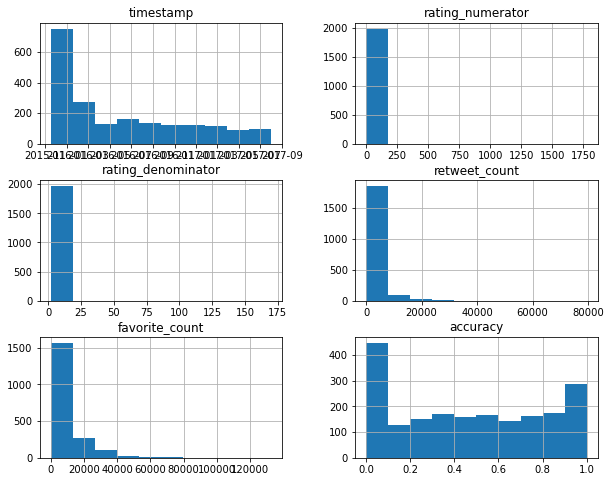

In [51]:
# Plotting histogram of master data set
complete_df.hist(figsize=(10,8));

Retweet and favourite counts are right skewed while rating numerator is left skewed and rating denominator is approximately constant

### Visualization

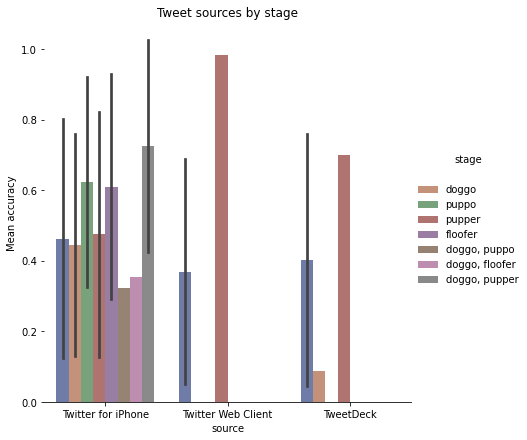

In [52]:
# Plotting clients used to tweet
g = sns.catplot(
    data=complete_df, kind="bar",
    x="source", y="accuracy", hue="stage",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("source", "Mean accuracy")
g.legend.set_title("stage")
g.set(title= 'Tweet sources by stage');

## Insight 1: Above bar plot shows that most users used iphones to rate the dogs

[Text(0.5, 1.0, 'Correlation between favorite and retweet counts')]

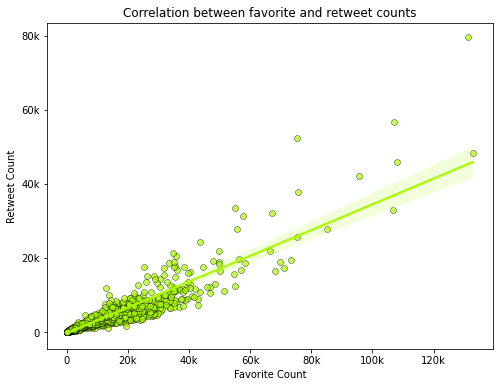

In [53]:
#Plotting Correlation between favorite and retweet counts
fig, ax = plt.subplots(figsize=(8,6))
n = sns.regplot(complete_df.favorite_count, complete_df.retweet_count, 
           color='#A8FB01',
           ax=ax,
           scatter_kws={'alpha': 0.7, 'edgecolor': 'k', 'linewidth': 0.5})
plt.xlabel('Favorite Count')
plt.ylabel('Retweet Count')
plt.xticks([0,20000,40000,60000,80000,100000,120000],
           ['0','20k','40k','60k','80k','100k','120k'])
plt.yticks([0,20000,40000,60000,80000],
           ['0','20k','40k','60k','80k']);
n.set(title='Correlation between favorite and retweet counts')

## Insight 2: Above scatter plot shows that favorite and retweet counts have positive correlation.

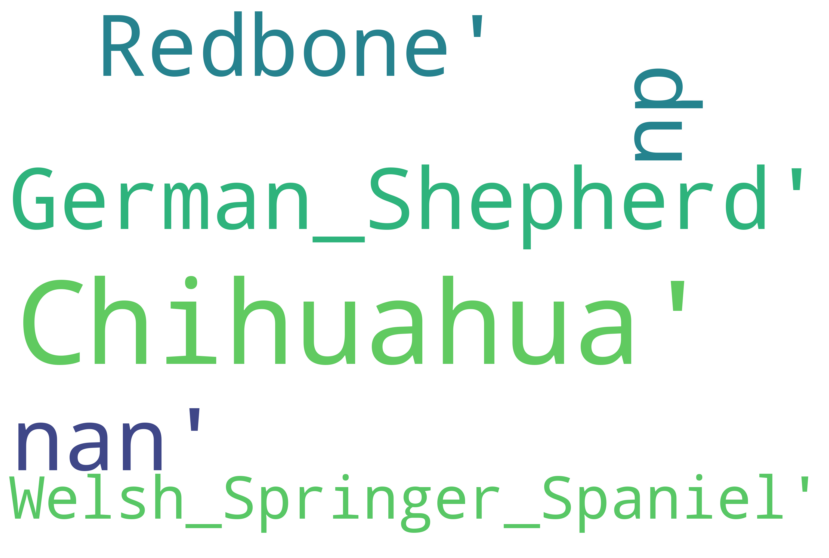

In [54]:
# Displaying most popular dog breeds
text = complete_df.predict.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Insight 3:  Above Word cloud shows top 4 most predicted dog breeds

In [55]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1986 non-null   object             
 1   timestamp           1986 non-null   datetime64[ns, UTC]
 2   source              1986 non-null   object             
 3   text                1986 non-null   object             
 4   expanded_urls       1986 non-null   object             
 5   rating_numerator    1986 non-null   float64            
 6   rating_denominator  1986 non-null   float64            
 7   name                1986 non-null   object             
 8   stage               1986 non-null   object             
 9   retweet_count       1986 non-null   int64              
 10  favorite_count      1986 non-null   int64              
 11  jpg_url             1986 non-null   object             
 12  predict             1986 non-null 

In [56]:
Dogp = complete_df[complete_df['rating_denominator'] >= 10] 

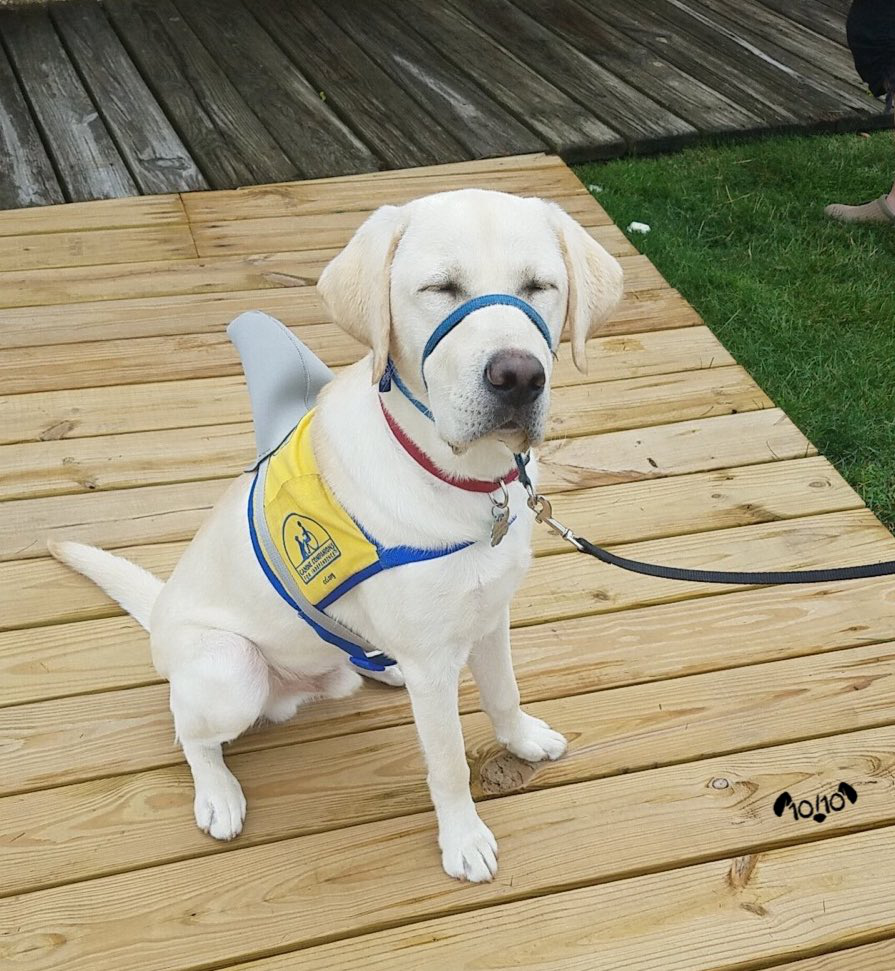

In [57]:
url = Dogp.jpg_url.iloc[11]
r = requests.get(url)
Image.open(BytesIO(r.content))

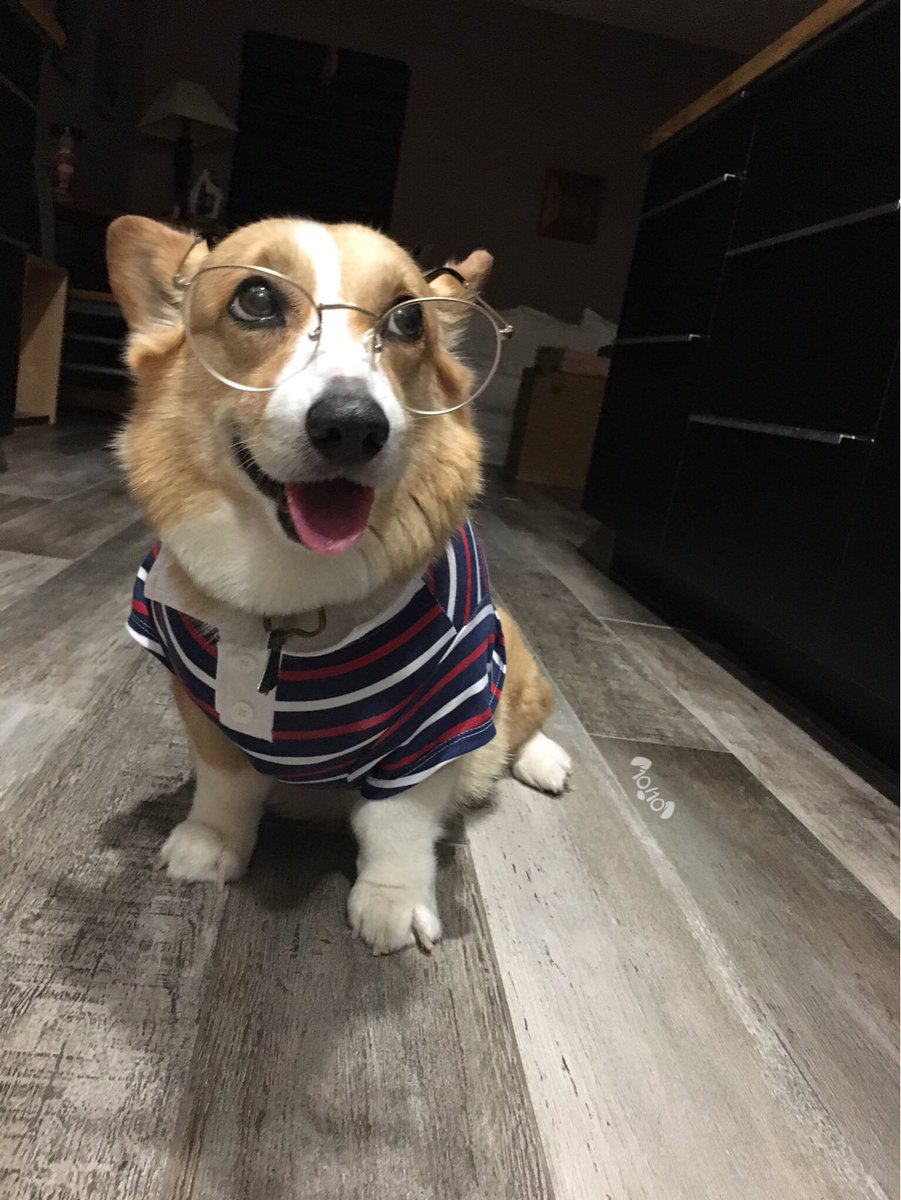

In [58]:
url = Dogp.jpg_url.iloc[9]
r = requests.get(url)
Image.open(BytesIO(r.content))

<a id="conclusion"></a>
## Conclusion

Our data set was having multiple data to visualize and get insights from, but we focused on only three which gives a whole overview. Further visualization can be done like plotting a bar chart that shows most popular dog names and dogs with highest ratings. Pie chart of predicted dogs images compared with other animals to show the prediction accuracy.